# Facial Recognition with Tensorflow and FaceNet

This is a basic test of the FaceNet implementation from the following github library:

https://github.com/davidsandberg/facenet/wiki

I want to evaluate the following:
* Whether it's feasible to roll our own facial recognition
* Test how well it scales (e.g. if we have 10 / 100 / 500+ users)
* Use this as a baseline to compare against off-the-shelf APIs (such as Azure Face API and Amazon Rekognition)

### Import libraries

In [148]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
import argparse
import facenet
import lfw
import os
import sys
import math
import pandas as pd
from sklearn import metrics
from scipy.optimize import brentq
from scipy import interpolate
import pickle
from sklearn.svm import SVC
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline


### Training and classifying code

In [65]:
class WrongAnswer():
    def __init__(self, predicted, actual, test_filepath, train_dirpath, actual_dirpath):
        self.predicted = predicted
        self.predicted_name = os.path.basename(train_dirpath)
        self.actual = actual
        self.actual_name = os.path.basename(actual_dirpath)
        self.test_filepath = test_filepath
        self.train_dirpath = train_dirpath
        self.actual_dirpath = actual_dirpath

In [170]:
def classifier(mode, # = 'CLASSIFY', 
               data_dir, # = '../data/subset/train', 
               classifier_filename, # = '../data/subset/subset_classifier.pkl', 
               model = '../data/models/20170512-110547.pb', 
               use_split_dataset = False, 
               test_data_dir = '../data/subset/test', 
               batch_size=90, 
               image_size=160, 
               seed=666, 
               min_nrof_images_per_class=20, 
               nrof_train_images_per_class=10):
  
    with tf.Graph().as_default():
      
        with tf.Session() as sess:
            
            np.random.seed(seed=seed)
            
            if use_split_dataset:
                dataset_tmp = facenet.get_dataset(data_dir)
                train_set, test_set = split_dataset(dataset_tmp, min_nrof_images_per_class, nrof_train_images_per_class)
                if (mode=='TRAIN'):
                    dataset = train_set
                elif (mode=='CLASSIFY'):
                    dataset = test_set
            else:
                dataset = facenet.get_dataset(data_dir)

            # Check that there are at least one training image per class
            for cls in dataset:
                assert(len(cls.image_paths)>0, 'There must be at least one image for each class in the dataset')            

            paths, labels = facenet.get_image_paths_and_labels(dataset)
            
            results = pd.DataFrame([len(dataset)], columns=['Classes'])
            
            print('Number of classes: %d' % len(dataset))
            print('Number of images: %d' % len(paths))
            
            # Load the model
            print('Loading feature extraction model')
            facenet.load_model(model)
            
            # Get input and output tensors
            images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
            embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
            phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
            embedding_size = embeddings.get_shape()[1]
            
            # Run forward pass to calculate embeddings
            print('Calculating features for images')
            nrof_images = len(paths)
            nrof_batches_per_epoch = int(math.ceil(1.0*nrof_images / batch_size))
            emb_array = np.zeros((nrof_images, embedding_size))
            for i in range(nrof_batches_per_epoch):
                start_index = i*batch_size
                end_index = min((i+1)*batch_size, nrof_images)
                paths_batch = paths[start_index:end_index]
                images = facenet.load_data(paths_batch, False, False, image_size)
                feed_dict = { images_placeholder:images, phase_train_placeholder:False }
                emb_array[start_index:end_index,:] = sess.run(embeddings, feed_dict=feed_dict)
            
            classifier_filename_exp = os.path.expanduser(classifier_filename)

            if (mode=='TRAIN'):
                # Train classifier
                print('Training classifier')
                model = SVC(kernel='linear', probability=True)
                model.fit(emb_array, labels)
            
                # Create a list of class names
                class_names = [ cls.name.replace('_', ' ') for cls in dataset]

                # Saving classifier model
                with open(classifier_filename_exp, 'wb') as outfile:
                    pickle.dump((model, class_names), outfile)
                print('Saved classifier model to file "%s"' % classifier_filename_exp)
                
            elif (mode=='CLASSIFY'):
                # Classify images
                print('Testing classifier')
                with open(classifier_filename_exp, 'rb') as infile:
                    (model, class_names) = pickle.load(infile)

                print('Loaded classifier model from file "%s"' % classifier_filename_exp)

                predictions = model.predict_proba(emb_array)
                best_class_indices = np.argmax(predictions, axis=1)
                best_class_probabilities = predictions[np.arange(len(best_class_indices)), best_class_indices]
                
                for i in range(len(best_class_indices)):
                    msg = "WRONG!!!"
                    
                    if np.equal(best_class_indices[i], labels[i]):
                        msg = "Correct"
                    else:
                        wrong = WrongAnswer(best_class_indices[i], 
                                            labels[i], 
                                            paths[i], 
                                            os.path.dirname(paths[best_class_indices[i]]),
                                            os.path.dirname(paths[i])
                                           )
                        
                        print("\nPredicted:", wrong.predicted, "(" + wrong.predicted_name + "), Actual:", wrong.actual, "(" + wrong.actual_name + ")")
                        print(wrong.test_filepath)
                        print(wrong.train_dirpath)
                        print(wrong.actual_dirpath)
                        
                        
#                     print("\nReading " + os.path.basename(paths[i]) + "... " + msg)

#                     print('%4d  %s: %.3f' % (i, class_names[best_class_indices[i]], best_class_probabilities[i]))

                    
                accuracy = np.mean(np.equal(best_class_indices, labels))
                print('\nAccuracy: %.3f' % accuracy)
            
    return results

            
def split_dataset(dataset, min_nrof_images_per_class, nrof_train_images_per_class):
    train_set = []
    test_set = []
    for cls in dataset:
        paths = cls.image_paths
        # Remove classes with less than min_nrof_images_per_class
        if len(paths)>=min_nrof_images_per_class:
            np.random.shuffle(paths)
            train_set.append(facenet.ImageClass(cls.name, paths[:nrof_train_images_per_class]))
            test_set.append(facenet.ImageClass(cls.name, paths[nrof_train_images_per_class:]))
    return train_set, test_set

<ipython-input-170-9902f73a940e>:31: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(cls.image_paths)>0, 'There must be at least one image for each class in the dataset')


In [171]:
from IPython.display import display, HTML

def train_and_classify(root_dir):
    classifier(mode = "TRAIN", 
           data_dir = os.path.join(root_dir, "train"), 
           classifier_filename = os.path.join(root_dir, "classifier.pkl"))
    
    results = classifier(mode = 'CLASSIFY', 
           data_dir = os.path.join(root_dir, "test"), 
           classifier_filename = os.path.join(root_dir, "classifier.pkl"))
    
    display(results)

### Simple test with 9 people

This example has 9 people, with 9 training images and 9 testing images.

For the training images, we duplicate the 9 images to make 18 training images, as this algorithm can't handle only 1 training image per person. This is a very crude implementation of Data Augmentation.

This test was 100% accurate with its predictions.

In [172]:
train_and_classify("../data/subset_small")

Number of classes: 9
Number of images: 18
Loading feature extraction model
Model filename: ../data/models/20170512-110547.pb
Calculating features for images
Training classifier
Saved classifier model to file "../data/subset_small\classifier.pkl"
Number of classes: 9
Number of images: 9
Loading feature extraction model
Model filename: ../data/models/20170512-110547.pb
Calculating features for images
Testing classifier
Loaded classifier model from file "../data/subset_small\classifier.pkl"

Accuracy: 1.000


,Classes
0,9


### Bigger test with 100 people

This example has 100 people, with 200 training images and 100 testing images.

This test was 89% accurate with its predictions.

In [151]:
train_and_classify("../data/newdir_train2_test1")

Number of classes: 100
Number of images: 200
Loading feature extraction model
Model filename: ../data/models/20170512-110547.pb
Calculating features for images
Training classifier
Saved classifier model to file "../data/newdir_train2_test1\classifier.pkl"
Number of classes: 100
Number of images: 100
Loading feature extraction model
Model filename: ../data/models/20170512-110547.pb
Calculating features for images
Testing classifier
Loaded classifier model from file "../data/newdir_train2_test1\classifier.pkl"

Predicted: 20 (Alastair_Campbell), Actual: 15 (Akhmed_Zakayev)
../data/newdir_train2_test1\test\Akhmed_Zakayev\Akhmed_Zakayev_0003.png
../data/newdir_train2_test1\test\Alastair_Campbell
../data/newdir_train2_test1\test\Akhmed_Zakayev

Predicted: 3 (Abdullah_Gul), Actual: 23 (Alejandro_Avila)
../data/newdir_train2_test1\test\Alejandro_Avila\Alejandro_Avila_0003.png
../data/newdir_train2_test1\test\Abdullah_Gul
../data/newdir_train2_test1\test\Alejandro_Avila

Predicted: 71 (Arturo_


Predicted: 20 (Alastair_Campbell), Actual: 15 (Akhmed_Zakayev)
../data/newdir_train2_test1/test\Akhmed_Zakayev\Akhmed_Zakayev_0003.png
../data/newdir_train2_test1/test\Alastair_Campbell
../data/newdir_train2_test1/test\Akhmed_Zakayev

Predicted: 3 (Abdullah_Gul), Actual: 23 (Alejandro_Avila)
../data/newdir_train2_test1/test\Alejandro_Avila\Alejandro_Avila_0003.png
../data/newdir_train2_test1/test\Abdullah_Gul
../data/newdir_train2_test1/test\Alejandro_Avila

Predicted: 71 (Arturo_Gatti), Actual: 24 (Alejandro_Toledo)
../data/newdir_train2_test1/test\Alejandro_Toledo\Alejandro_Toledo_0003.png
../data/newdir_train2_test1/test\Arturo_Gatti
../data/newdir_train2_test1/test\Alejandro_Toledo

Predicted: 65 (Arlen_Specter), Actual: 33 (Alvaro_Noboa)
../data/newdir_train2_test1/test\Alvaro_Noboa\Alvaro_Noboa_0003.png
../data/newdir_train2_test1/test\Arlen_Specter
../data/newdir_train2_test1/test\Alvaro_Noboa

Predicted: 53 (Ann_Veneman), Actual: 41 (Ana_Palacio)
../data/newdir_train2_test1/te

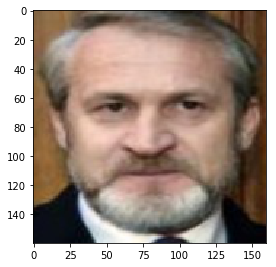

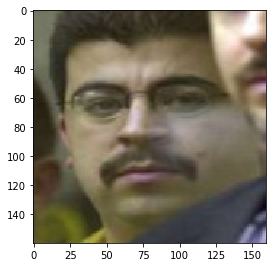

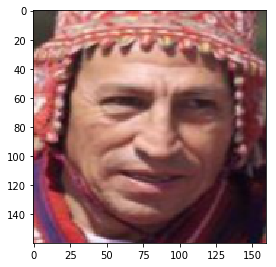

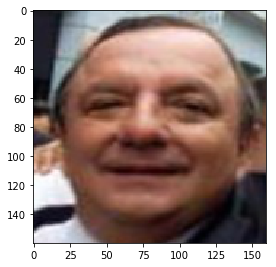

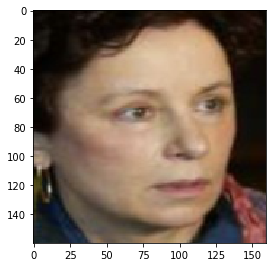

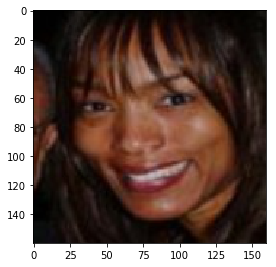

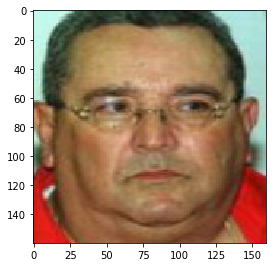

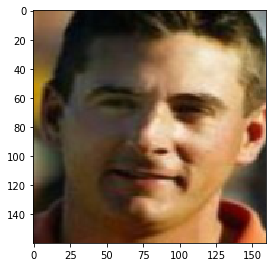

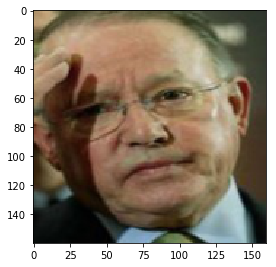

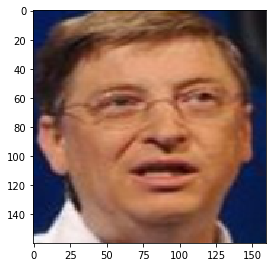

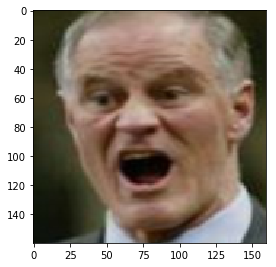

In [115]:
i = 1

for wrong in wrongs:
    print("\nPredicted:", wrong.predicted, "(" + wrong.predicted_name + "), Actual:", wrong.actual, "(" + wrong.actual_name + ")")
    print(wrong.test_filepath)
    print(wrong.train_dirpath)
    print(wrong.actual_dirpath)
#     pil_im = Image.open(wrong.test_filepath, 'r')
#     plt.figure(figsize=(30, 30))
#     plt.subplot(6,2,i)
    
#     plt.imshow(np.asarray(pil_im))
#     i += 1
                    

### Test with 500 people

This example has 500 people, with 1000 training images and 500 testing images.

This test was 79.4% accurate with its predictions.

In [144]:
train_and_classify("../data/newdir_train2_test1_total500")

Number of classes: 500
Number of images: 1000
Loading feature extraction model
Model filename: ../data/models/20170512-110547.pb
Calculating features for images
Training classifier
Saved classifier model to file "../data/newdir_train2_test1_total500\classifier.pkl"
Number of classes: 500
Number of images: 500
Loading feature extraction model
Model filename: ../data/models/20170512-110547.pb
Calculating features for images
Testing classifier
Loaded classifier model from file "../data/newdir_train2_test1_total500\classifier.pkl"

Reading Alastair_Campbell_0003.png... WRONG!!!

Reading Alejandro_Toledo_0003.png... WRONG!!!

Reading Alex_Sink_0003.png... WRONG!!!

Reading Alvaro_Noboa_0003.png... WRONG!!!

Reading Anders_Ebbeson_0003.png... WRONG!!!

Reading Anna_Kournikova_0003.png... WRONG!!!

Reading Arlen_Specter_0003.png... WRONG!!!

Reading Arnold_Palmer_0003.png... WRONG!!!

Reading Arnoldo_Aleman_0003.png... WRONG!!!

Reading Bernard_Landry_0003.png... WRONG!!!

Reading Bill_Gates_

In [145]:
train_and_classify("../data/newdir_train1_test1_total500")

Number of classes: 500
Number of images: 1000
Loading feature extraction model
Model filename: ../data/models/20170512-110547.pb
Calculating features for images
Training classifier
Saved classifier model to file "../data/newdir_train1_test1_total500\classifier.pkl"
Number of classes: 500
Number of images: 500
Loading feature extraction model
Model filename: ../data/models/20170512-110547.pb
Calculating features for images
Testing classifier
Loaded classifier model from file "../data/newdir_train1_test1_total500\classifier.pkl"

Reading Alison_Lohman_0002.png... WRONG!!!

Reading Anna_Nicole_Smith_0002.png... WRONG!!!

Reading Bridgette_Wilson-Sampras_0002.png... WRONG!!!

Reading Charles_Schumer_0002.png... WRONG!!!

Reading Chen_Liang_Yu_0002.png... WRONG!!!

Reading Christina_Aguilera_0002.png... WRONG!!!

Reading Claire_Danes_0002.png... WRONG!!!

Reading Constance_Marie_0002.png... WRONG!!!

Reading Courtney_Love_0002.png... WRONG!!!

Reading Cristina_Fernandez_0002.png... WRONG!!!

In [146]:
train_and_classify("../data/newdir_train5_test1_total500")

Number of classes: 311
Number of images: 1555
Loading feature extraction model
Model filename: ../data/models/20170512-110547.pb
Calculating features for images
Training classifier
Saved classifier model to file "../data/newdir_train5_test1_total500\classifier.pkl"
Number of classes: 311
Number of images: 311
Loading feature extraction model
Model filename: ../data/models/20170512-110547.pb
Calculating features for images
Testing classifier
Loaded classifier model from file "../data/newdir_train5_test1_total500\classifier.pkl"

Reading John_Howard_0006.png... WRONG!!!

Reading Nicole_Kidman_0006.png... WRONG!!!

Accuracy: 0.994


In [147]:
train_and_classify("../data/newdir_train1_test1_total1000")

Number of classes: 1000
Number of images: 2000
Loading feature extraction model
Model filename: ../data/models/20170512-110547.pb
Calculating features for images
Training classifier
Saved classifier model to file "../data/newdir_train1_test1_total1000\classifier.pkl"
Number of classes: 1000
Number of images: 1000
Loading feature extraction model
Model filename: ../data/models/20170512-110547.pb
Calculating features for images
Testing classifier
Loaded classifier model from file "../data/newdir_train1_test1_total1000\classifier.pkl"

Reading Alison_Lohman_0002.png... WRONG!!!

Reading Anna_Nicole_Smith_0002.png... WRONG!!!

Reading Bernard_Landry_0002.png... WRONG!!!

Reading Bill_Paxton_0002.png... WRONG!!!

Reading Bridgette_Wilson-Sampras_0002.png... WRONG!!!

Reading Charles_Bronson_0002.png... WRONG!!!

Reading Charles_Schumer_0002.png... WRONG!!!

Reading Christina_Aguilera_0002.png... WRONG!!!

Reading Claire_Danes_0002.png... WRONG!!!

Reading Constance_Marie_0002.png... WRONG!!

### Results